In [155]:
import polars as pl
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import altair as alt

In [2]:
# read in the data
df = pl.read_csv("../../rethinking/data/Howell1.csv", separator=";")
df.describe()

statistic,height,weight,age,male
str,f64,f64,f64,f64
"""count""",544.0,544.0,544.0,544.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",138.263596,35.610618,29.344393,0.472426
"""std""",27.602448,14.719178,20.746888,0.499699
"""min""",53.975,4.252425,0.0,0.0
"""25%""",125.095,22.010552,12.0,0.0
"""50%""",148.59,40.086193,27.0,0.0
"""75%""",157.48,47.201918,43.0,1.0
"""max""",179.07,62.992589,88.0,1.0


Notice the weight distribution in this dataset is a little.. unusual!

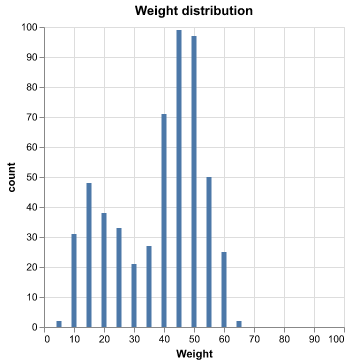

/var/folders/14/s48byhxn7hv56zs0vky9xz6r0000gp/T/ipykernel_25660/1796727308.py:5: UserWarning: Automatically deduplicated selection parameter with identical configuration. If you want independent parameters, explicitly name them differently (e.g., name='param1', name='param2'). See https://github.com/vega/altair/issues/3891
  df.plot.scatter(x="age", y="weight").properties(


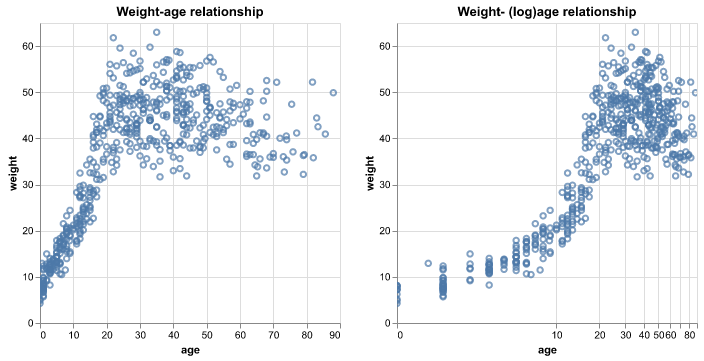

In [167]:
df["weight"].hist(bins=np.arange(0, 100, 5)).plot.bar(
    x=alt.X("breakpoint", title="Weight"), y="count"
).properties(title="Weight distribution").display()

df.plot.scatter(x="age", y="weight").properties(
    title="Weight-age relationship"
) | df.plot.scatter(x=alt.X("age").scale(type="symlog"), y="weight").properties(
    title="Weight- (log)age relationship"
)

## Doing prior predictive simulation manually

The homework asks to set up a prior predictive simulation for the influence of age on weight. We'll assume a simple linear model 
$$\text{weight} = Normal(\mu = \alpha + \beta * \text{age}, \sigma)$$

Side note: based on the charts above, it may actually make more sense to assume a linear relationship with `log(age)` - you can try that yourself.

First, we need to specify priors. 

* In this model, $\alpha$ is the weight at age zero, so it has to be positive, but probably not too big. I'm going to assume... up to 7kg? I'll also pretend that I know nothing about biology and so a uniform distribution of 0-7kg seems as an easy choice.

* For $\beta$, it's reasonable to assume that it has to be positive (weight goes up with age), but it's a little harder to guess what the coefficient should be. One way to think about it is to ask "what's the typical maximum possible" - I'd wager.. 150 kg or so? Given typical max age of ~80, that suggests a $\beta$ of up to 2. Again, we'll go with uniform distribution first as a guess.

* $\sigma$ is the standard deviation of the noise component. People can vary in weight a lot, so our $\sigma$ needs to be pretty large here. Let's give it an extreme value - something like $\sigma=50$.

Implementation-wise, there are couple of ways you could draw from uniform distributions. `scipy` has a good stats library, for example. Let's use that.

In [3]:
from scipy.stats import uniform, norm

num_samples = 100

alpha_prior = uniform.rvs(loc=0, scale=7, size=num_samples)
beta_prior = uniform.rvs(loc=0, scale=2, size=num_samples)
sigma_prior = uniform.rvs(loc=0, scale=50, size=num_samples)


Now, let's grab age values from the data.

In [4]:
ages = df.select("age").to_series().to_numpy()

And let's generate some weights using our priors. I'm doing this all in one vectorized numpy multiplication, but you could also achieve it with for loops.

The resulting `expected_weights` array has the shape of 544 x 100, i.e. 100 predictions for each age in the dataset.

In [5]:
expected_weights = alpha_prior + beta_prior * ages.reshape(-1, 1)
expected_weights.shape

(544, 100)

These are just the expectations (mean weights at each age). We want to incorporate the variance component, and so we need to draw from normal distribution based on our model specification.

In [6]:
actual_weights = norm.rvs(expected_weights, sigma_prior)


Let's add this to a dataframe to make it easier to work with.

In [7]:
actual_weights.shape

(544, 100)

In [ ]:
result_df = pl.DataFrame(
    {
        "age": ages,
        "weights": actual_weights,
        "alpha": alpha_prior.reshape(1, -1).repeat(len(ages), axis=0),
        "beta": beta_prior.reshape(1, -1).repeat(len(ages), axis=0),
        "sigma": sigma_prior.reshape(1, -1).repeat(len(ages), axis=0),
    }
)


result_df.head()

age,weights,alpha,beta,sigma
f64,"array[f64, 100]","array[f64, 100]","array[f64, 100]","array[f64, 100]"
63.0,"[146.495113, 112.45991, … 84.723918]","[3.501587, 3.566473, … 5.669856]","[1.693396, 1.90613, … 1.448748]","[48.066964, 11.92758, … 40.804021]"
63.0,"[61.099031, 115.623672, … 122.541345]","[3.501587, 3.566473, … 5.669856]","[1.693396, 1.90613, … 1.448748]","[48.066964, 11.92758, … 40.804021]"
65.0,"[4.106159, 149.473428, … 102.487026]","[3.501587, 3.566473, … 5.669856]","[1.693396, 1.90613, … 1.448748]","[48.066964, 11.92758, … 40.804021]"
41.0,"[43.019272, 88.724398, … 97.542738]","[3.501587, 3.566473, … 5.669856]","[1.693396, 1.90613, … 1.448748]","[48.066964, 11.92758, … 40.804021]"
51.0,"[63.256408, 116.310106, … 50.040682]","[3.501587, 3.566473, … 5.669856]","[1.693396, 1.90613, … 1.448748]","[48.066964, 11.92758, … 40.804021]"


We'll explode this to individual rows

In [ ]:
exploded_df = result_df.explode(["alpha", "beta", "sigma", "weights"])

And we'll visualize the results. I'll sample them to 5000 data points to make the chart less heavy.

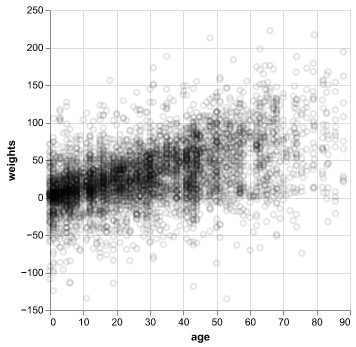

In [ ]:
import altair as alt

alt.renderers.enable("png")

alt.Chart(exploded_df.sample(5000)).mark_point(opacity=0.1, color="black").encode(
    x="age", y="weights"
)

Admittedly, this is not a great set of priors/model specifications. We get negative weights, the max weight is also not that high.. But it's not completely illogical!

## Using PyMC

We can also do the above using PyMC, which helps abstract away some of the details. Replicating the model above:

In [ ]:
with pm.Model(coords={"obs": np.arange(len(df))}) as basic_model:
    # set priors
    alpha = pm.Uniform("alpha", 0, 7)
    beta = pm.Uniform("beta", 0, 2)
    sigma = pm.Uniform("sigma", 0, 50)

    # assign data
    X = pm.Data("X", df.select("age").to_series().to_numpy(), dims="obs")

    mu = alpha + beta * ages
    weights = pm.Normal("weights", mu=mu, sigma=sigma, dims="obs")

We can visualize the model:

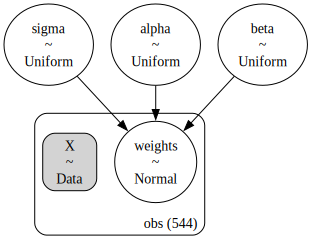

In [12]:
basic_model.to_graphviz()

Now, we can do prior predictive sampling:

In [ ]:
with basic_model:
    results = pm.sample_prior_predictive(
        samples=num_samples, var_names=["weights", "alpha", "beta", "sigma"]
    )

Sampling: [alpha, beta, sigma, weights]


The `prior_pred` is a xArray object that contains the all the information captured during the sampling.

In [14]:
results

Inference data with groups:
	> prior
	> constant_data

We can use this data to produce a similar plot to above

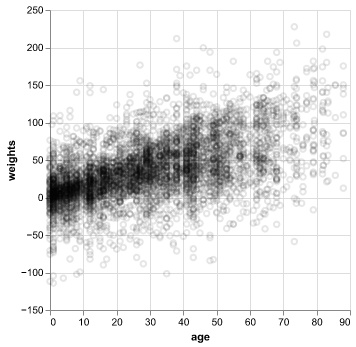

In [ ]:
df_pymc_results = pl.DataFrame(
    {"age": ages, "weights": results.prior["weights"].isel(chain=0).to_numpy().T}
).explode(["weights"])

alt.Chart(df_pymc_results.sample(5000)).mark_point(opacity=0.1, color="black").encode(
    x="age", y="weights"
)

Or, we can also produce a chart of slopes & intercepts like the one in the lecture:

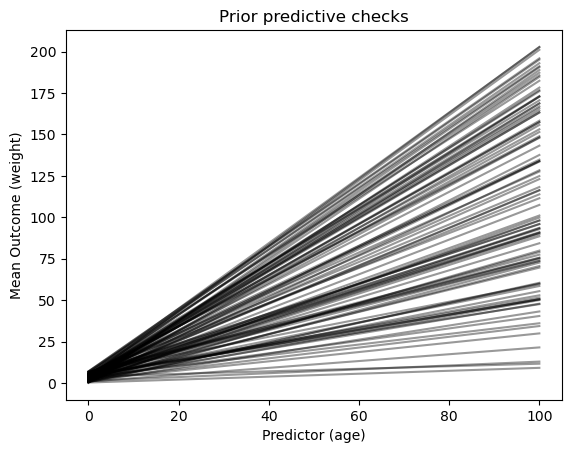

In [20]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(0, 100, 100), dims=["obs"])
prior = results.prior
y = prior["alpha"] + prior["beta"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (age)")
ax.set_ylabel("Mean Outcome (weight)")
ax.set_title("Prior predictive checks");

## Fitting to the actual data

So far, we haven't actually been fitting the data. Let's do that now.

In [ ]:
# assign data to weights parameter of the model
observed_model = pm.observe(
    basic_model, {"weights": df.select("weight").to_series().to_numpy()}
)


# fit using MCMC and extend the results object
with observed_model:
    results.extend(
        pm.sample(
            draws=1000,
            tune=1000,
            chains=4,
        )
    )

    # and add posterior predictive samples
    results.extend(pm.sample_posterior_predictive(results))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [weights]


Output()

Now, the results object contains the posterior samples

In [73]:
results

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> observed_data
	> constant_data

We can use `arviz` library to visualize and summarize the results. Looks like we learned a model where:
 * $\alpha = 6.9$
 * $\beta = 0.8$
 * $\sigma = 13.7$

Their mean values, that is - we learned distributions for each of them. In fact, if we plot posterior distributions, we will see that $\alpha$ distribution is very much peaking at the boundary of the prior - we only allowed it to take max value of 7! So the model learned something within our constraints, but likely it isn't the best model..

In [74]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,13.719,0.416,12.920,14.467,0.008,0.006,2807.0,2774.0,1.0
beta,0.812,0.017,0.780,0.843,0.000,0.000,3472.0,2798.0,1.0
alpha,6.930,0.068,6.803,7.000,0.001,0.002,2487.0,1327.0,1.0


array([<Axes: title={'center': 'sigma'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'alpha'}>], dtype=object)

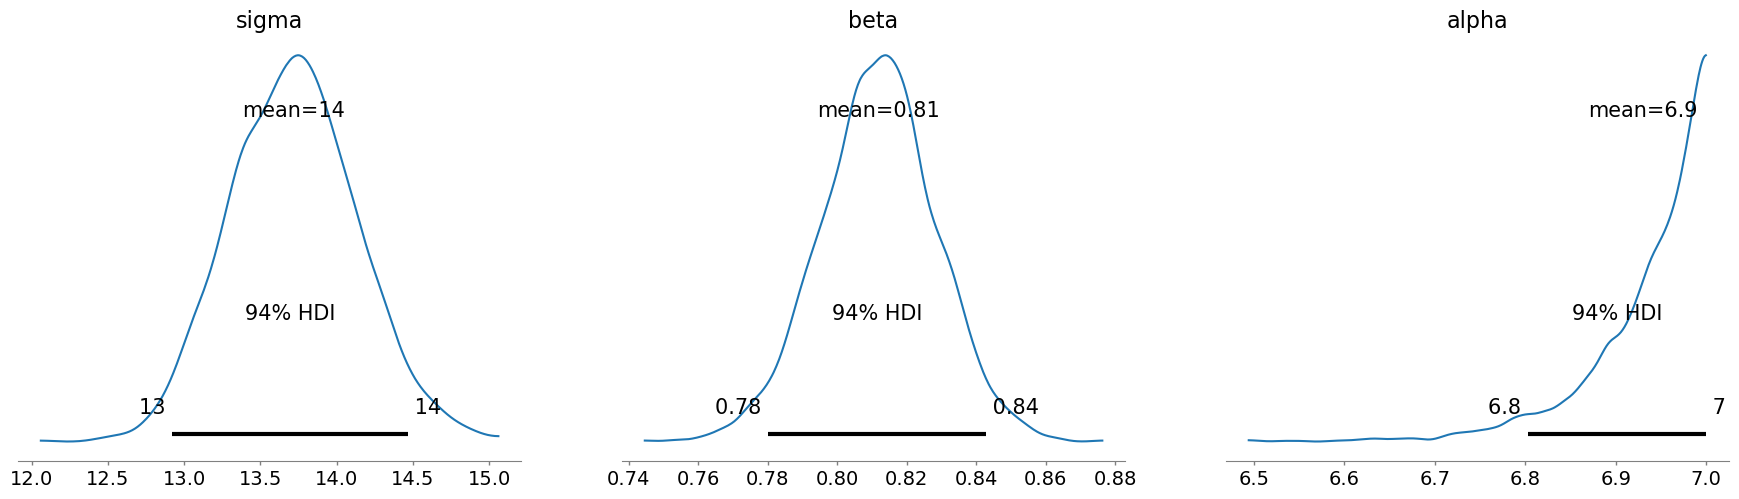

In [75]:
az.plot_posterior(results)

We can also compare how observed weights correspond to the model predictions - not soo well.

<Axes: xlabel='weights'>

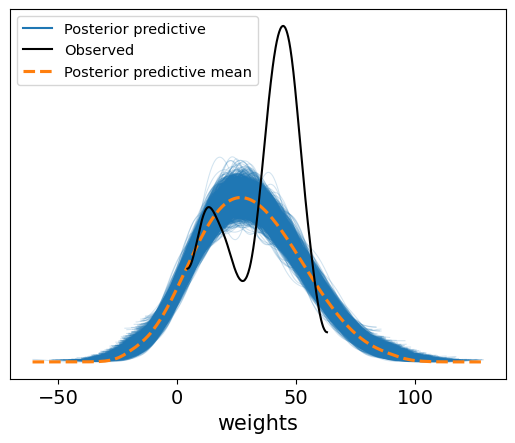

In [76]:
az.plot_ppc(results)

## A better model

Let's build a model that fits the data better. We'll use both age and height as indicators. Additionally, we will model weight as a LogNormal distribution to allow for longer tails. And, finally, just for the fun of it, we will build in an extra component to variance to model variances as a function of height and age - with the idea that weight varies more as people get taller and/or older.

In [ ]:
with pm.Model(
    coords={
        "obs": np.arange(len(df)),
        "predictors": ["age", "height"],
        "parameters": ["mean", "sigma"],
    }
) as better_model:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    slopes = pm.Normal("slopes", mu=0, sigma=2, dims=("parameters", "predictors"))
    baseline_sigma = pm.Exponential("baseline_sigma", lam=1)

    X = pm.Data("X", df.select("age").to_series().to_numpy(), dims="obs")
    H = pm.Data("H", df.select("height").to_series().to_numpy(), dims="obs")
    Y = pm.Data("Y", df.select("weight").to_series().to_numpy(), dims="obs")

    mu = intercept + slopes[0, 0] * X + slopes[0, 1] * H
    sigma_slopes_exp = pm.Deterministic(
        "sigma_slopes", slopes[1, :].exp(), dims=("predictors")
    )
    sigma = baseline_sigma + (sigma_slopes_exp[0] * X + sigma_slopes_exp[1] * H)

    weights = pm.LogNormal("weights", mu=mu, sigma=sigma, dims="obs", observed=Y)


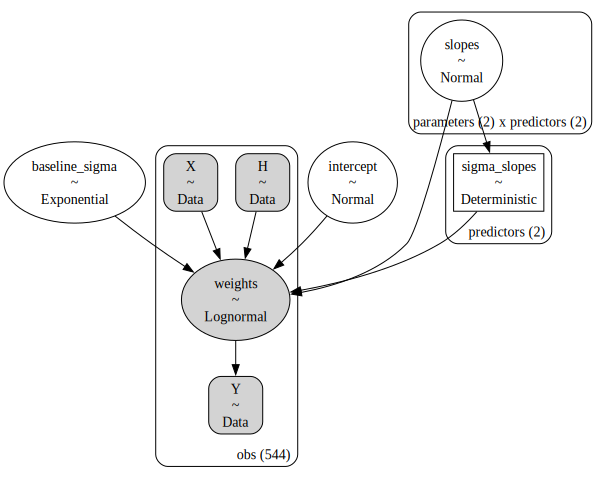

In [146]:
better_model.to_graphviz()

In [ ]:
with better_model:
    better_results = pm.sample_prior_predictive(samples=num_samples)


Sampling: [baseline_sigma, intercept, slopes, weights]


with better_model:
    better_results.extend(pm.sample())
    better_results.extend(pm.sample_posterior_predictive(better_results))


In [150]:
az.summary(better_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.653,0.024,0.607,0.698,0.001,0.000,1952.0,2079.0,1.0
"slopes[mean, age]",0.001,0.000,0.001,0.002,0.000,0.000,2081.0,2358.0,1.0
"slopes[mean, height]",0.020,0.000,0.019,0.020,0.000,0.000,1799.0,1783.0,1.0
"slopes[sigma, age]",-8.258,0.516,-9.200,-7.358,0.011,0.012,2400.0,1808.0,1.0
"slopes[sigma, height]",-9.051,0.578,-10.112,-8.052,0.014,0.012,1761.0,1943.0,1.0
baseline_sigma,0.080,0.009,0.062,0.095,0.000,0.000,1950.0,2172.0,1.0
sigma_slopes[age],0.000,0.000,0.000,0.001,0.000,0.000,2400.0,1808.0,1.0
sigma_slopes[height],0.000,0.000,0.000,0.000,0.000,0.000,1761.0,1943.0,1.0


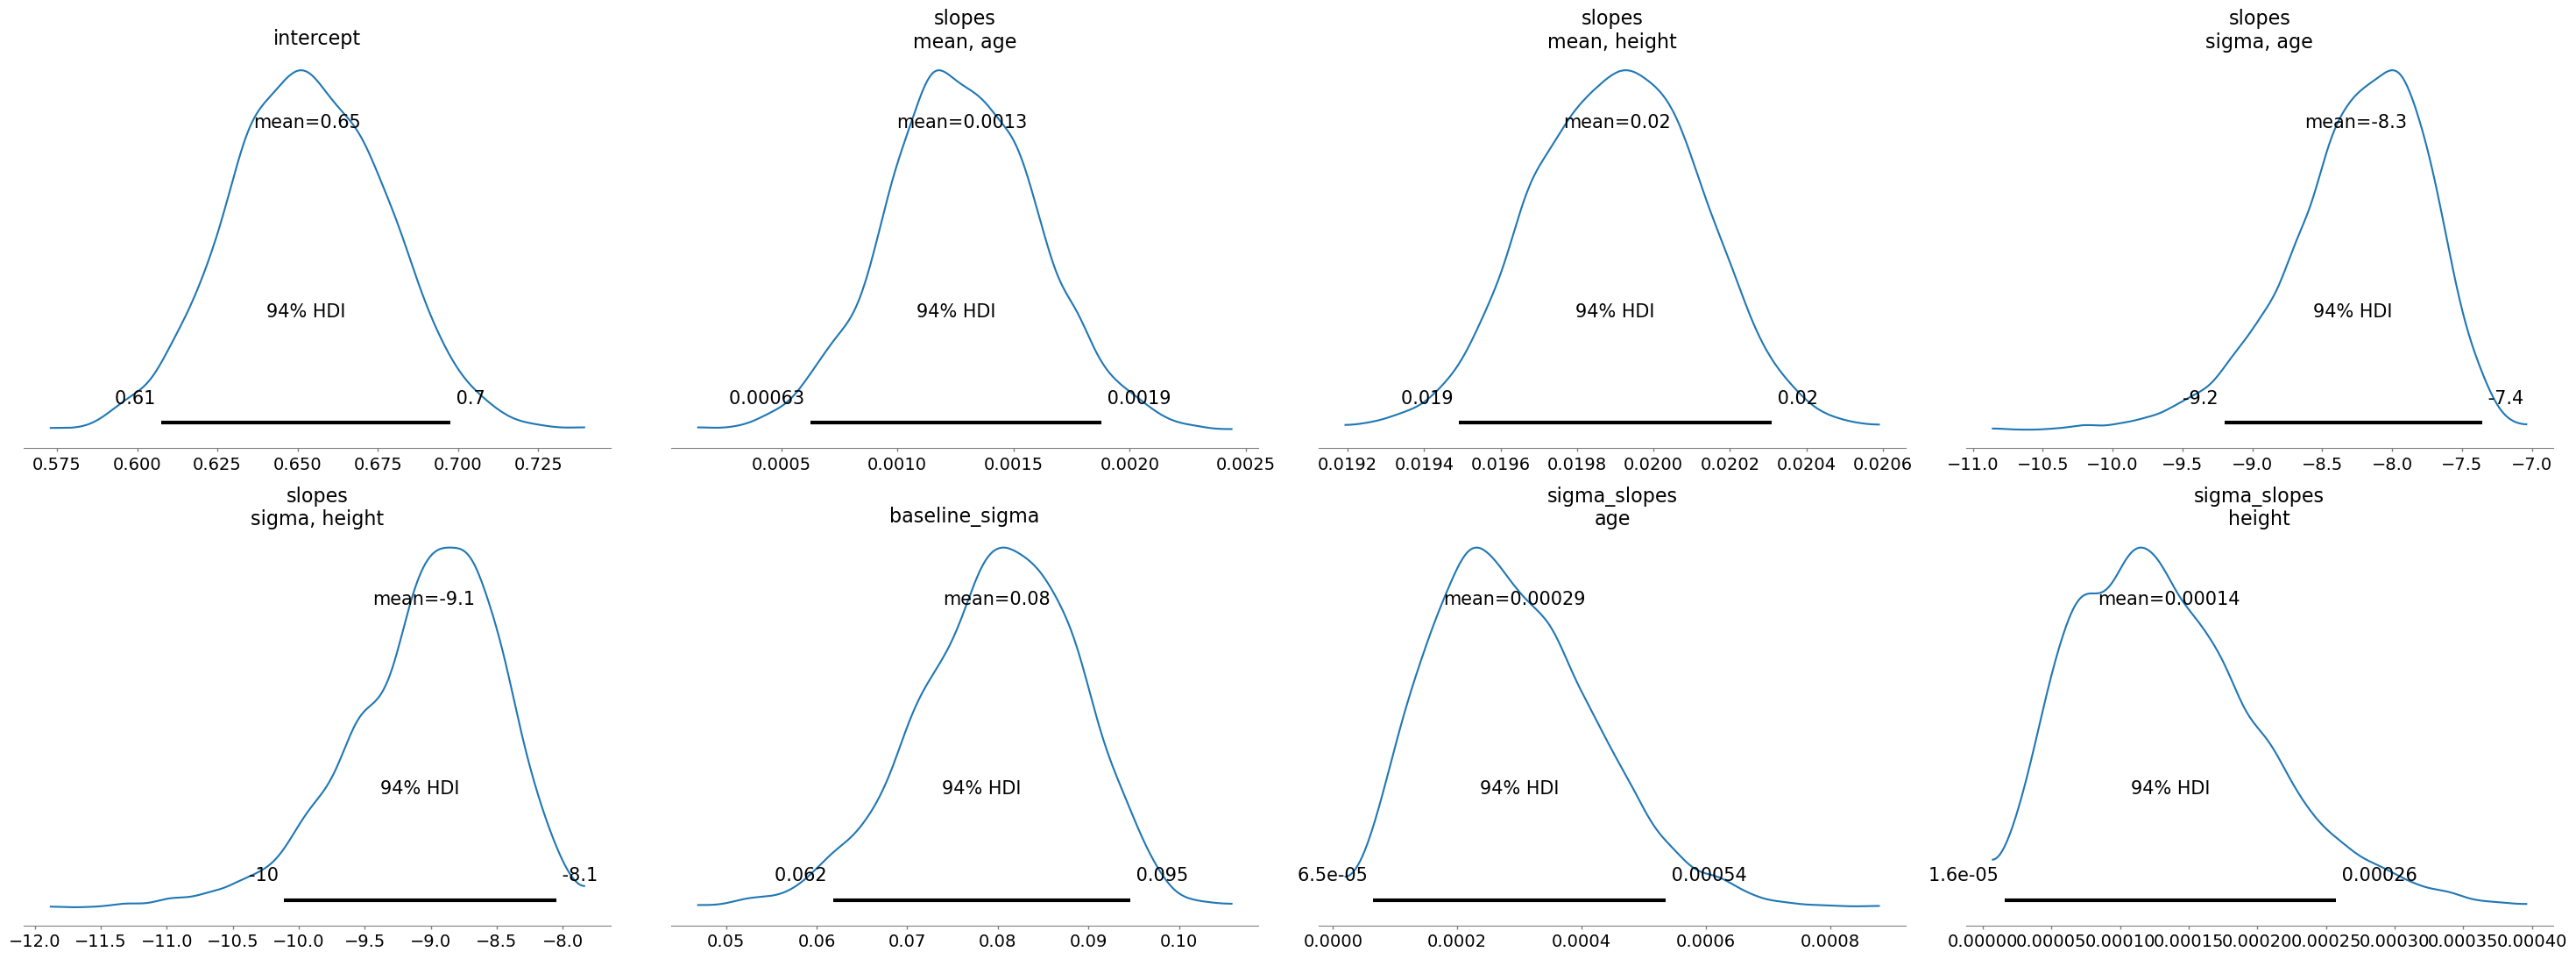

In [151]:
az.plot_posterior(better_results)
plt.tight_layout()

<Axes: xlabel='weights'>

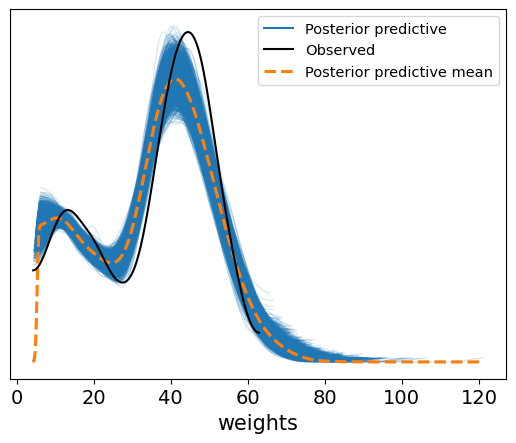

In [152]:
az.plot_ppc(better_results)

Must better fit! We can also see that age and height specific variance components are effectively zero - so our hypothesis that weight varies more with age was wrong. Cool.